# Generative Adversarial Networks

**XBUS-512: Introduction to AI and Deep Learning**

In this exercise, we will see how to build a generative adversarial network using the MNIST digits dataset. 

*Note: this lab is inspired by [this blog post](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) by Jason Brownlee.*


In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from keras.datasets.mnist import load_data
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Conv2D, Flatten, Dropout, ReLU, Reshape, Conv2DTranspose

## Load the data 
This will also download the data if it has not been already.

The data consists of 70,000 images of handwritten digits, each represented as a 28×28 pixel grayscale image. The target column (`y`) is the label of for each image, represented as integers between 0 and 9.

The `load_data` function from Keras will split the data into 60,000/10,000 for training and testing, respectively, scale the data between 0 and 1, and then using `numpy` to expand the input data dimensionality from 2 to 3.

In [2]:
(X_train, y_train), (X_test, y_test) = load_data()

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)


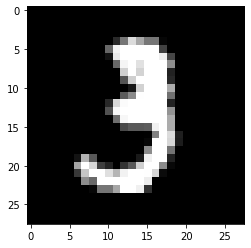

In [3]:
# We can inspect the images using matplotlib:
plt.imshow(X_train[10], cmap="gray")

## The Discriminator

First we will create a discriminator, which will learn how to distinguish real images from synthetic images.

Our discriminator will have two convolutional layers of 64 filters each, a convolutional window (kernel) of 3, and a stride of 2. The output layer uses a sigmoidal activation function to perform binary classification (real image or fake image), minimizing the binary cross entropy loss function.

In [4]:
class Discriminator():
    """
    The GAN's discriminator
    """
    
    def __init__(
        self, 
        filters=64,
        kernel=(3, 3),
        strides=(2, 2),
        padding="same", 
        optimizer=Adam(),
        metrics=["accuracy"], 
        activation="sigmoid", 
        input_shape=(28, 28, 1),
        loss="binary_crossentropy",
    ):
        """
        Parameters
        ----------
        loss : string (default: "binary_crossentropy")
            String (name of objective function), objective function or
            `tf.keras.losses.Loss` instance.

        kernel : tuple (default: (3,3))
            Specifies the height & width of the 2D convolutional window.

        strides : tuple (default: (2, 2))
            The strides of the convolution along the height & width.
                        
        filters : integer (default: 64)
            The dimensionality of the output space.
            
        padding : string, one of "valid" or "same" (default: "same")
            One of "valid" or "same" (case-insensitive). 
            "valid" means no padding. "same" results in padding evenly
            to the left/right or up/down of the input such that output
            has the same height/width dimension as the input.

        optimizer : keras.optimizer (default: Adam())
            String (name of optimizer) or optimizer instance.
            See `tf.keras.optimizers`.

        metrics : list of string (default: ["accuracy"])
            List of metrics to be evaluated by the model during training
            and testing. Each of this can be a string
            (name of a built-in function), function or a
            `tf.keras.metrics.Metric` instance.
            
        activation : string (default: "sigmoid")
            Activation function to use. See `keras.activations`
            
        input_shape : tuple (default: (28, 28, 1))
            The input shape of the data in pixels.
        """
        self.loss = loss
        self.kernel = kernel
        self.strides = strides
        self.filters = filters
        self.padding = padding
        self.metrics = metrics
        self.optimizer = optimizer
        self.activation = activation
        self.input_shape = input_shape
        
        self.build()
        
    def build(self):
        """
        Build the model architecture
        """
        self.model = Sequential()
        self.model.add(Conv2D(
            self.filters,
            self.kernel,
            strides=self.strides,
            padding=self.padding, 
            input_shape=self.input_shape
        ))
        self.model.add(ReLU())
        self.model.add(Dropout(0.4))
        self.model.add(Conv2D(
            self.filters,
            self.kernel,
            strides=self.strides,
            padding=self.padding
        ))
        self.model.add(ReLU())
        self.model.add(Dropout(0.4))
        self.model.add(Flatten())
        self.model.add(Dense(1, activation=self.activation))

        self.model.compile(
            loss=self.loss, 
            optimizer=self.optimizer, 
            metrics=self.metrics
        )

    def make_fakes(self, n_samples):
        """
        Generate uniform random numbers in [0,1], 
        reshape into a batch of grayscale images,
        generate fake class labels (0), and return the
        synthetic data
        """
        X = rand(28 * 28 * n_samples)
        X = X.reshape((n_samples, 28, 28, 1))
        y = np.zeros((n_samples, 1))
        return X, y

    def train(self, X, n_iter=100, n_batch=256):
        """
        Loop over the training data, iteratively updating
        the discriminator on real samples, generating fake samples,
        updating the discriminator on the fakes, and summarizing
        the model's performance
        """
        half_batch = int(n_batch / 2)
        for i in range(n_iter):
            y = np.ones((len(X), 1))
            _, real_acc = self.model.train_on_batch(X[:half_batch], y[:half_batch])
            X_fake, y_fake = self.make_fakes(half_batch)
            _, fake_acc = self.model.train_on_batch(X_fake, y_fake)
            print("Iteration {}: real={} fake={}".format(
                i+1, real_acc*100, fake_acc*100
            ))

In [5]:
discriminator = Discriminator()
discriminator.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [6]:
discriminator.train(X_train)

Iteration 1: real=39.0625 fake=11.71875
Iteration 2: real=91.40625 fake=65.625
Iteration 3: real=93.75 fake=98.4375
Iteration 4: real=89.0625 fake=100.0
Iteration 5: real=90.625 fake=100.0
Iteration 6: real=85.15625 fake=100.0
Iteration 7: real=78.90625 fake=100.0
Iteration 8: real=80.46875 fake=100.0
Iteration 9: real=86.71875 fake=100.0
Iteration 10: real=92.1875 fake=100.0
Iteration 11: real=92.1875 fake=100.0
Iteration 12: real=98.4375 fake=100.0
Iteration 13: real=99.21875 fake=100.0
Iteration 14: real=100.0 fake=100.0
Iteration 15: real=100.0 fake=100.0
Iteration 16: real=100.0 fake=100.0
Iteration 17: real=100.0 fake=100.0
Iteration 18: real=100.0 fake=100.0
Iteration 19: real=100.0 fake=100.0
Iteration 20: real=100.0 fake=100.0
Iteration 21: real=100.0 fake=100.0
Iteration 22: real=100.0 fake=100.0
Iteration 23: real=100.0 fake=100.0
Iteration 24: real=100.0 fake=100.0
Iteration 25: real=100.0 fake=100.0
Iteration 26: real=100.0 fake=100.0
Iteration 27: real=100.0 fake=100.0
It

## The Generator

Next we will create a generator, which will learn how to create new "handwritten" digits.

In [7]:
class Generator():
    """
    The GAN's Generator
    """
    def __init__(
        self, 
        kernel=(4, 4),
        strides=(3, 3),
        padding="same", 
        activation="sigmoid", 
        latent_dimensions=100
    ):
        """
        Parameters
        ----------
        kernel : tuple (default: (4,4))
            Specifies the height & width of the 2D convolutional window.

        strides : tuple (default: (2, 2))
            The strides of the convolution along the height & width.
            
        padding : string, one of "valid" or "same" (default: "same")
            One of "valid" or "same" (case-insensitive). 
            "valid" means no padding. "same" results in padding evenly
            to the left/right or up/down of the input such that output
            has the same height/width dimension as the input.
            
        activation : string (default: "sigmoid")
            Activation function to use. See `keras.activations`
            
        latent_dimensions : int (default: 100)
            Number of latent dimensions in the deep learning model
        """
        self.kernel = kernel
        self.strides = strides
        self.padding = padding
        self.activation = activation
        self.latent = latent_dimensions
    
        self.build()
        
    def build(self):
        """
        Construct a Sequential model with a Dense layer capable
        of producing 7x7 images. 
        Upsample the dimensions first to 14x14, and then to 28x28
        """
        self.model = Sequential()
        n_nodes = 128 * 7 * 7
        self.model.add(Dense(n_nodes, input_dim=self.latent))
        self.model.add(ReLU())
        self.model.add(Reshape((7, 7, 128)))
        self.model.add(Conv2DTranspose(
            128, 
            self.kernel, 
            strides=self.strides, 
            padding=self.padding
        ))
        self.model.add(ReLU())
        self.model.add(Conv2DTranspose(
            128, 
            self.kernel, 
            strides=self.strides, 
            padding=self.padding
        ))
        self.model.add(ReLU())
        self.model.add(Conv2D(
            1, 
            (7, 7), 
            activation=self.activation, 
            padding=self.padding
        ))

In [8]:
generator = Generator()
generator.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 21, 21, 128)       262272    
_________________________________________________________________
re_lu_3 (ReLU)               (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 63, 63, 128)       262272    
_________________________________________________________________
re_lu_4 (ReLU)               (None, 63, 63, 128)      